
### OVERVIEW 

This final project is important for us to test your technical abilities working with a real database and making sure you can communicate them in English, please try to respond in English. 

### GOALS

Create a dashboard for our leaders with KPI's that you believe make sense to measure at Grin

Create a forecast model to predict one of the two following options: 

* Rides between 2018-09-17 -> 2018-10-16 
* Clustering to identify our different types of users


### SPECIFICATIONS

There isn't a specific tool to develop this challenge, feel free to use what you consider best or what you are most familiar. Please, send us the dashboard and the model including all the code necessary for development.



***

In [29]:
# Install all the dependencies
import psycopg2  
import pprint  
import pandas.io.sql as psql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from datetime import date
from sklearn import preprocessing
import datashader as ds
import pandas as pd
from colorcet import fire
from datashader import transfer_functions as tf
%matplotlib inline


In [178]:
# Print the different tables in the database schema.
conn = psycopg2.connect(dbname='postgres', user='grin_technical_challenge', password='kjbaskc24bkjhb354bbjk', host='grin-technical-test.crf3v8rvj0hp.us-east-1.rds.amazonaws.com', port='5432', sslmode='require')
cursor = conn.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print cursor.fetchall()


[('rides',), ('open_app',)]


In [14]:
# Save to a File in case my kernel dies.
df = pd.read_sql_query('SELECT *  FROM scooter_event', con=conn)
df.to_csv('rides.csv')
df2 = pd.read_sql_query('SELECT *  FROM open_app', con=conn)
df2.to_csv('open_app.csv')

In [58]:
# Read from file
df_file = pd.read_csv('rides.csv')
df2_file = pd.read_csv('open_app.csv')

In [235]:
# Limit the results to avoid memory issues.
#      2684712
size = 2684712
df = df_file.head(size)
df2 = df2_file.head(size)

***
# 1.   Dashboard KPI

### Topography Heatmap Hotspots

We would like to know where the scooters have been used the most in Sao Paulo ciy. This heatmaps shows the distribution of said pickups. The red area denotes the points where most users unlocked a scooter. We can see that there is a high concentraton of scooter usage right in the center of the city.

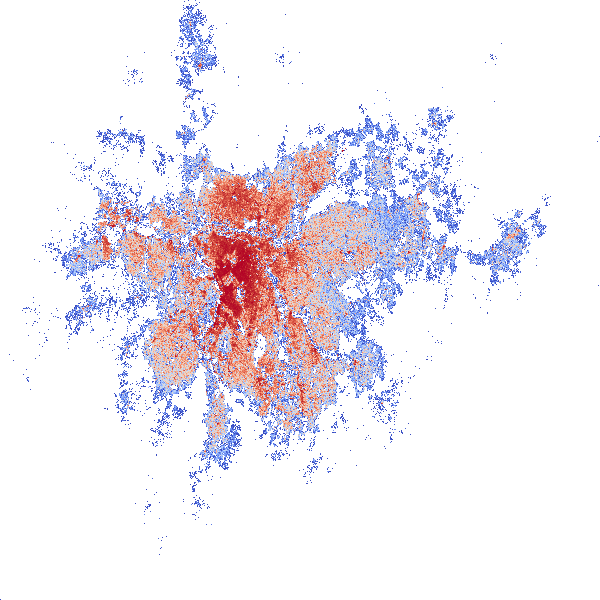

In [238]:
agg = ds.Canvas().points(df_test, 'starting_lng', 'starting_lat')
tf.set_background(tf.shade(agg, cmap=plt.cm.coolwarm),"white")

Another interesting measurement could be the duration of each trip, we could visualize this information by month, by day or even by year using a bar chart and grouping by date. However, we could also use a distribution plot although this could be too technical for a KPI dashboard, nevetheless it is always interesting as a data scientist to analize one.

The average time is: 20 minutes.


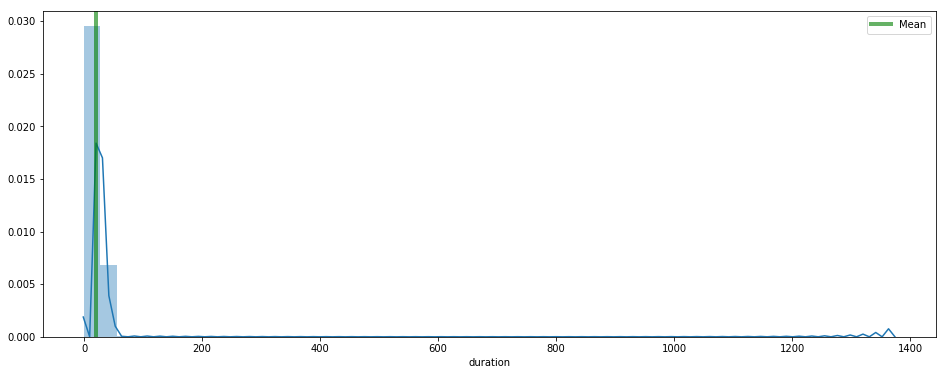

In [247]:
df['finish_time'] = pd.to_datetime( df['finish_time'])
df['start_time'] = pd.to_datetime( df['start_time'])
df['duration'] = df['finish_time'] - df['start_time']
duration = df['duration']
duration_min = duration.dt.seconds / 60
fig, ax = plt.subplots(figsize=(16, 6))
ax = sns.distplot(duration_min)
plt.axvline(x=duration_min.mean(),alpha=0.6, c ='g', lw=4, label='Mean')
plt.legend()
print 'The average time is: {} minutes.'.format(int(duration_min.mean()))

Another interesting KPI could be which scooter has the most use. This is important in case we want plan its maintentance period or want to know its lifetime. From the plot below we can tell that scooter number `65176` has been used the most and probable we would like to repace it in a close future.

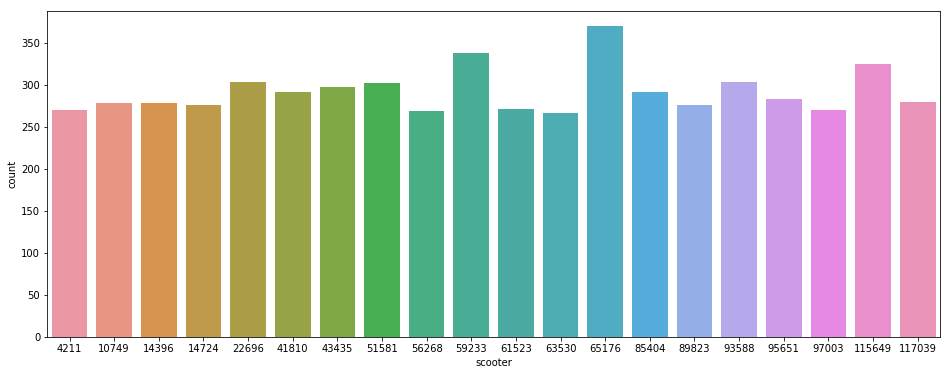

In [282]:
# count the number of times a scooter has been used.
scooter_id_count = (df['scooter_id']
       .value_counts()
       .rename_axis('scooter')
       .reset_index(name='count'))
scooter_id_count = scooter_id_count.sort_values(by=['count'],ascending=False) # sort by count
fig, ax = plt.subplots(figsize=(16, 6))
ax = sns.barplot(x="scooter", y="count", data=scooter_id_count.head(20)) # show only top 20

Perhaps we want to know which users are the ones that use the app the most. Maybe futher the line we want to offer them discounts or prices for their loyalty.

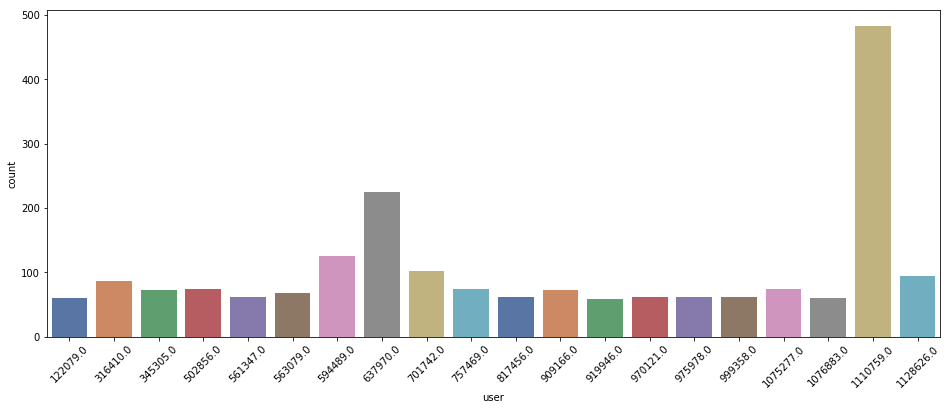

In [298]:
# count the number of times a scooter has been used.
user_id_count = (df2['user_id']
       .value_counts()
       .rename_axis('user')
       .reset_index(name='count'))
scooter_id_count = user_id_count.sort_values(by=['count'],ascending=False) # sort by count
fig, ax = plt.subplots(figsize=(16, 6))
ax = sns.barplot(x="user", y="count", data=user_id_count.head(20), palette="deep") # show only top 2
for item in ax.get_xticklabels():
    item.set_rotation(45)

Another important KPI is how much money we are making each day. We could use a linear regression to fit our data and have an idea on how we are doing. Later we will find out that this has a high correlation with the season

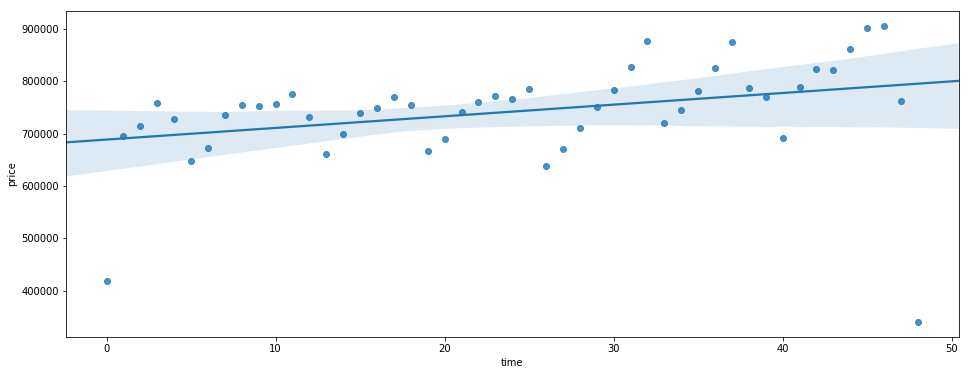

In [340]:
price_day = df[['start_time', 'price']]
price_day = price_day.set_index('start_time').groupby(pd.Grouper(freq='D')).sum() # group by day and sum
price_day = price_day.loc['2018-07-31':]
price_day['time'] = range(0,price_day.shape[0])
fig, ax = plt.subplots(figsize=(16, 6))
ax = sns.regplot(x="time", y="price", data=price_day)

Some other Dashboards Ideas are:

* Get the most used routes based on the coordinates.
* Show the distance of each user (km).
* Time spent on the app per user.
* ROI per scooter and per user.
* How many rides per day


***

# 2.   Forecast Rides between 2018-09-17 -> 2018-10-16

In [112]:
# we count how many rides per day.
rides_by_day = (pd.to_datetime(df['start_time'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('date')
       .reset_index(name='count'))

In [115]:
rides_by_day.set_index(rides_by_day['date'], inplace = True) # re-index for plotting
rides_by_day.sort_index(inplace = True)

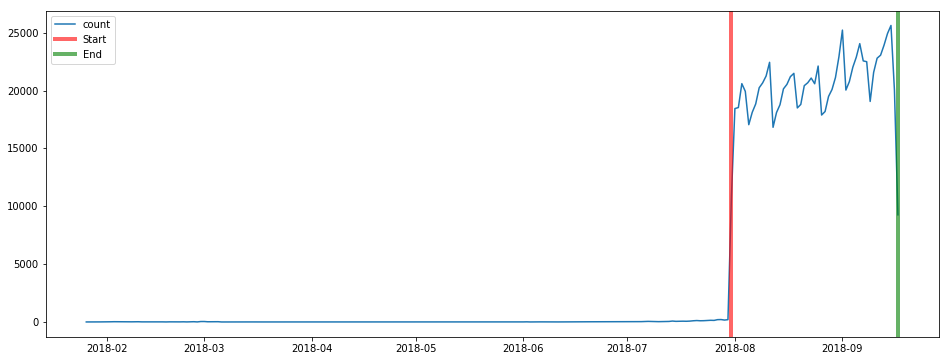

In [123]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot( rides_by_day['count'])
plt.axvline(x='2018-07-31',alpha=0.6, c ='r', lw=4, label='Start')
plt.axvline(x='2018-09-17',alpha=0.6, c ='g', lw=4, label='End')
plt.legend()

From the plot we can notice that the quality of the dataset is not good for a proper forecast, therefore we will use data only from `2018-08`.

In [142]:
df_fb = rides_by_day.loc['2018-07-31':]
df_fb.columns = ['ds', 'y']
df_fb = rides_by_day.loc['2018-07-31':]
df_fb.columns = ['ds', 'y']
future = pd.DataFrame(pd.date_range(start='2018-09-17', end='2018-10-16'))
future.columns = ['ds']
from fbprophet import Prophet
m = Prophet()
m.fit(df_fb)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


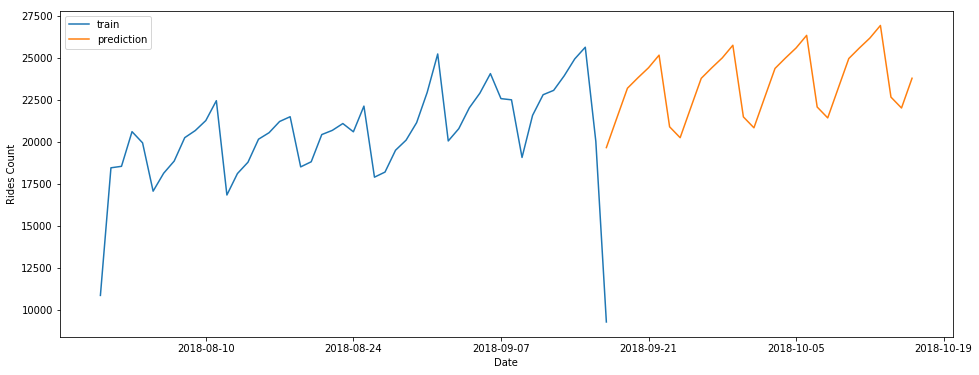

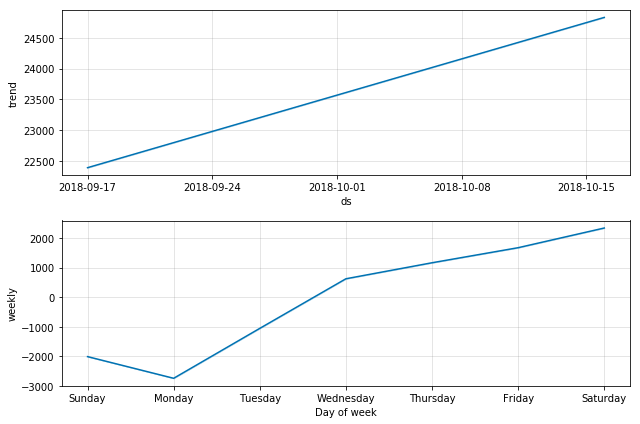

In [176]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(df_fb.set_index('ds')['y'], label = 'train')
plt.plot(forecast.set_index('ds')['yhat'], label = 'prediction')
plt.ylabel('Rides Count')
plt.xlabel('Date')
plt.legend()
fig2= m.plot_components(forecast)

There are many ways to make this prediction, for this particular this case, I chose Prophet because it is quick and easy to use. Prophet is a FB library for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.  But we could have done this with another ML model such as: SVR, forest regression, etc. Since we are working with timeseries data it would have been more difficult to implement since we need to do some feature extraction. Feature extraction in this case it is very important because we care about seasonality, trends, and more. We could have also used ARIMA models. As an example, we can make the hypothesis that on weekends, holidays or summer, people tend to use more scooters. From the final result we can see an upward trend, being Saturday the day with more scooters usage. Of course, this is just a teaser of what a proper ML could have been.

# Clustering to identify our different types of users.

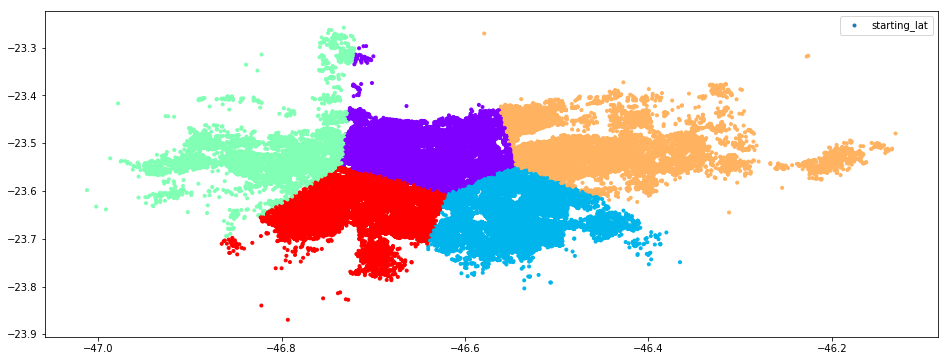

In [17]:
#@title Clustering
from sklearn.cluster import KMeans
df_km = df_test[['starting_lng', 'starting_lat']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_km)
fig, ax = plt.subplots(figsize=(16, 6))
plt.scatter(df_test['starting_lng'], df_test['starting_lat'], c=kmeans.labels_, cmap='rainbow', marker='.')
plt.legend()

This is just an example how we could use K-Means as a clustering techinique. I decided to split the territory in 5 clusters and show potential users by area. This snows a pretty basic market segmentation case.